# Group 4 - Tempo Estimation 

### Features Used
- For plotting:
    - RMS energy
    - Onsets
- For estimating a tempo:
    - RMS energy
    - Periodicity analysis (autocorrelation of energy derivative)

### Signal Flow
1. Input signal
2. Find RMS energy of signal
3. Find derivative of RMSE
4. Take only positive values to evaluate onsets
5. Autocorrelate derivative for periodicity analysis
6. Take only autocorrelation above a threshold
7. Find time difference values at strong AC values
8. Filter possible time difference values
9. Convert to tempo

### Future Improvments
- Use spectral features to determine the genre of the song and set a range for estimating the tempo. 
- Determine the best autocorrelation threshold for different genres of music

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import statistics
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import load, feature, frames_to_time, autocorrelate, clicks
import librosa as lb
plt.rcParams['figure.figsize'] = (16, 4)

In [2]:
###### Read Files #########
names = []
names_g = [] 
ground_dict = {}
for roots, dirs, files in os.walk('./Tempo_Audio'):
    for i in sorted(files):
        names.append(i)
        names_g.append(i.replace('mp3', 'bpm'))
All_files = names[1:]
names_g = names_g[1:]

for i in names_g:
    f = open('./tempo_textFiles/' + i, "r")
    x = i.split('.')
    ground_dict[x[0]] = f.read()

In [3]:
def plot_onsets(x, RMSenergy, sr, hop_length):
    t_energy = frames_to_time(range(len(RMSenergy)), sr=sr, hop_length=hop_length)
    time = np.linspace(0, x.size/sr, x.size)
    
    plt.plot(time, x, alpha=0.4)
    plt.plot(t_energy, RMSenergy, 'r--')
    
    onsetTimes = lb.onset.onset_detect(x, sr=sr, hop_length=hop_length, units='time')
    for i in onsetTimes:
        plt.axvline(x=i,linestyle='--',color='g')
    plt.legend(('Original Signal','RMS Energy','Onsets'))
    plt.xlim(0,10)

In [4]:
def Tempo(names, length, hop_len, frame_len, autocorr_threshold, graph=False):
    if type(names) is str:
        num = 1
    else:
        num = len(names)
    
    for i in range(0, num):
        if type(names) is str:
            (x, fs) = load('./Tempo_Audio/%s' % names, sr=None)
            check_str = True
        else:
            (x, fs) = load('./Tempo_Audio/%s' % names[i], sr=None)
            check_str = False
        xnorm = x/np.abs(x.max())
        xnorm = xnorm[0 : fs*length]

        # Calculate RMS Energy
        rmse = feature.rms(xnorm, frame_length=frame_len, hop_length=hop_len, center=True)
        rmse = rmse[0]

        # Calculate Derivative
        der = rmse[1:] - rmse[0:-1]
        der[der < 0] = 0 # Half rectified
        
        # Graphing parameter
        if graph == True:
            plot_onsets(xnorm, rmse, fs, hop_len)
            
        # Autocorrelation
        ac = autocorrelate(der)
        max_ac = ac[1:].max()
        ac_thresh = max_ac/autocorr_threshold 
        strongAC_indices = np.array([x for x in range(len(ac)) if ac[x] > ac_thresh])
        
        # time between high autocorrelation values
        frame_dur_sec = hop_len/fs # Time for one frame
        strongAC_times = frame_dur_sec * strongAC_indices
        strongAC_times = strongAC_times[2:] 
        timeDiffs = strongAC_times[1:] - strongAC_times[:-1]

        #Calculate Tempo
        timeDiffs_new = [] # Create a new list without repeated values
        for a in range(0, len(timeDiffs)):
            timeDiffs[a] = round(timeDiffs[a], 10)
            if timeDiffs[a] not in timeDiffs_new:
                timeDiffs_new.append(timeDiffs[a])
            else:
                next
        timeDiffs_new = np.array(timeDiffs_new) 
        tempo = 60 / timeDiffs_new # Calculated array of tempos

        # Find the largest value and divide the tempo range to normal value
        check = True
        for val in tempo:
            if val > 200:
                check = True
            else:
                check = False
        if check is True:
            tempo = tempo / 2

        # Determine one final tempo
        if len(tempo) != 0:
            tempo[tempo > 200] = 0
            while len(tempo) > 2: # Running through a while loop of finding median until the length is 2
                tempo[tempo < statistics.median(tempo)] = 0
                tempo = tempo[tempo != 0]
            final_tempo = statistics.mean(tempo) # Find the mean of the final two value
            final_tempo = round(final_tempo)            
        else:
            final_tempo = "Can't Calculate, try other parameter"
        
        if check_str == True:
            x = names
            split_x = x.split('.')
            print("File Name: ", x)
            print("Calculated Tempo: ", final_tempo)
            print("Ground Truth: ", ground_dict[split_x[0]], '\n')
        else:
            x = names[i].split('.')
            print("File Name: ", names[i])
            print("Calculated Tempo: ", final_tempo)
            print("Ground Truth: ", ground_dict[x[0]], '\n')

In [5]:
###### Estimate all the Audio Files ######

length = 120 # change how many seconds you want to analyze
hop_len = 512 # hop length for caculating RMS
frame_len = 1024 # frame length for caculating RMS
auto_thresh = 1.5 # threshold for correlation

names = All_files

Tempo(names, length, hop_len, frame_len, auto_thresh, graph=False)

File Name:  1030011.LOFI.mp3
Calculated Tempo:  128
Ground Truth:  126 

File Name:  1068430.LOFI.mp3
Calculated Tempo:  44
Ground Truth:  170 

File Name:  1084996.LOFI.mp3
Calculated Tempo:  166
Ground Truth:  140 

File Name:  1092771.LOFI.mp3
Calculated Tempo:  138
Ground Truth:  136 

File Name:  1114156.LOFI.mp3
Calculated Tempo:  43
Ground Truth:  86 

File Name:  1118326.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  171.419 

File Name:  1120171.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  174 

File Name:  1171800.LOFI.mp3
Calculated Tempo:  105
Ground Truth:  140 

File Name:  1174239.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  172 

File Name:  1177875.LOFI.mp3
Calculated Tempo:  150
Ground Truth:  148 

File Name:  1183908.LOFI.mp3
Calculated Tempo:  188
Ground Truth:  140 

File Name:  1198571.LOFI.mp3
Calculated Tempo:  122
Ground Truth:  120 

File Name:  122772.LOFI.mp3
Calculated Tempo:  166
Ground Truth:  140 

File Name:  1234668.LOFI.mp3
Calculated Tempo:  49


File Name:  278893.LOFI.mp3
Calculated Tempo:  150
Ground Truth:  145 

File Name:  28952.LOFI.mp3
Calculated Tempo:  148
Ground Truth:  137.6 

File Name:  2992360.LOFI.mp3
Calculated Tempo:  92
Ground Truth:  123 

File Name:  3013673.LOFI.mp3
Calculated Tempo:  46
Ground Truth:  157 

File Name:  3013772.LOFI.mp3
Calculated Tempo:  42
Ground Truth:  165 

File Name:  3016341.LOFI.mp3
Calculated Tempo:  131
Ground Truth:  128 

File Name:  3023605.LOFI.mp3
Calculated Tempo:  134
Ground Truth:  145 

File Name:  3040535.LOFI.mp3
Calculated Tempo:  35
Ground Truth:  140 

File Name:  3041381.LOFI.mp3
Calculated Tempo:  136
Ground Truth:  119 

File Name:  3041383.LOFI.mp3
Calculated Tempo:  188
Ground Truth:  176 

File Name:  3058700.LOFI.mp3
Calculated Tempo:  18
Ground Truth:  70 

File Name:  3059880.LOFI.mp3
Calculated Tempo:  126
Ground Truth:  128 

File Name:  3062661.LOFI.mp3
Calculated Tempo:  32
Ground Truth:  85 

File Name:  3069960.LOFI.mp3
Calculated Tempo:  142
Ground T

File Name:  3475672.LOFI.mp3
Calculated Tempo:  148
Ground Truth:  86 

File Name:  3480108.LOFI.mp3
Calculated Tempo:  154
Ground Truth:  130 

File Name:  3482508.LOFI.mp3
Calculated Tempo:  44
Ground Truth:  174 

File Name:  3482510.LOFI.mp3
Calculated Tempo:  21
Ground Truth:  85 

File Name:  3482733.LOFI.mp3
Calculated Tempo:  92
Ground Truth:  173 

File Name:  3484119.LOFI.mp3
Calculated Tempo:  48
Ground Truth:  122 

File Name:  3485917.LOFI.mp3
Calculated Tempo:  142
Ground Truth:  140 

File Name:  3486206.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  175 

File Name:  3492833.LOFI.mp3
Calculated Tempo:  146
Ground Truth:  140 

File Name:  3493047.LOFI.mp3
Calculated Tempo:  18
Ground Truth:  70 

File Name:  3509304.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  175 

File Name:  3511308.LOFI.mp3
Calculated Tempo:  111
Ground Truth:  150 

File Name:  3512227.LOFI.mp3
Calculated Tempo:  167
Ground Truth:  140 

File Name:  3519546.LOFI.mp3
Calculated Tempo:  169
Ground 

File Name:  3964688.LOFI.mp3
Calculated Tempo:  21
Ground Truth:  124 

File Name:  3970827.LOFI.mp3
Calculated Tempo:  93
Ground Truth:  180 

File Name:  3980001.LOFI.mp3
Calculated Tempo:  11
Ground Truth:  53 

File Name:  3981797.LOFI.mp3
Calculated Tempo:  128
Ground Truth:  128 

File Name:  3983645.LOFI.mp3
Calculated Tempo:  129
Ground Truth:  110 

File Name:  3983646.LOFI.mp3
Calculated Tempo:  117
Ground Truth:  140 

File Name:  400259.LOFI.mp3
Calculated Tempo:  22
Ground Truth:  173 

File Name:  4004314.LOFI.mp3
Calculated Tempo:  131
Ground Truth:  80 

File Name:  4004668.LOFI.mp3
Calculated Tempo:  131
Ground Truth:  128 

File Name:  4005630.LOFI.mp3
Calculated Tempo:  150
Ground Truth:  150 

File Name:  4006551.LOFI.mp3
Calculated Tempo:  9
Ground Truth:  144 

File Name:  4012083.LOFI.mp3
Calculated Tempo:  169
Ground Truth:  167 

File Name:  4014747.LOFI.mp3
Calculated Tempo:  122
Ground Truth:  125 

File Name:  4014749.LOFI.mp3
Calculated Tempo:  122
Ground T

File Name:  4353566.LOFI.mp3
Calculated Tempo:  122
Ground Truth:  126 

File Name:  4358231.LOFI.mp3
Calculated Tempo:  50
Ground Truth:  132 

File Name:  4360483.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  174 

File Name:  4360488.LOFI.mp3
Calculated Tempo:  148
Ground Truth:  174 

File Name:  4365752.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  87 

File Name:  4366506.LOFI.mp3
Calculated Tempo:  95
Ground Truth:  99 

File Name:  4372309.LOFI.mp3
Calculated Tempo:  125
Ground Truth:  125 

File Name:  4377106.LOFI.mp3
Calculated Tempo:  142
Ground Truth:  129 

File Name:  4381717.LOFI.mp3
Calculated Tempo:  70
Ground Truth:  140 

File Name:  4386702.LOFI.mp3
Calculated Tempo:  128
Ground Truth:  126 

File Name:  4397324.LOFI.mp3
Calculated Tempo:  103
Ground Truth:  174 

File Name:  4397469.LOFI.mp3
Calculated Tempo:  33
Ground Truth:  175 

File Name:  4398117.LOFI.mp3
Calculated Tempo:  111
Ground Truth:  178 

File Name:  4399289.LOFI.mp3
Calculated Tempo:  175
Groun

File Name:  4816604.LOFI.mp3
Calculated Tempo:  142
Ground Truth:  139.82 

File Name:  4823439.LOFI.mp3
Calculated Tempo:  142
Ground Truth:  140 

File Name:  4823611.LOFI.mp3
Calculated Tempo:  105
Ground Truth:  127 

File Name:  4826952.LOFI.mp3
Calculated Tempo:  117
Ground Truth:  140 

File Name:  4826957.LOFI.mp3
Calculated Tempo:  35
Ground Truth:  140 

File Name:  4827285.LOFI.mp3
Calculated Tempo:  175
Ground Truth:  172 

File Name:  4827287.LOFI.mp3
Calculated Tempo:  124
Ground Truth:  148 

File Name:  4845088.LOFI.mp3
Calculated Tempo:  181
Ground Truth:  180.0 

File Name:  4850346.LOFI.mp3
Calculated Tempo:  122
Ground Truth:  120 

File Name:  4853692.LOFI.mp3
Calculated Tempo:  106
Ground Truth:  126 

File Name:  4860099.LOFI.mp3
Calculated Tempo:  70
Ground Truth:  140 

File Name:  4861484.LOFI.mp3
Calculated Tempo:  144
Ground Truth:  172 

File Name:  4863146.LOFI.mp3
Calculated Tempo:  59
Ground Truth:  110 

File Name:  4875475.LOFI.mp3
Calculated Tempo:  3

File Name:  1327052.LOFI.mp3
Calculated Tempo:  178
Ground Truth:  175 



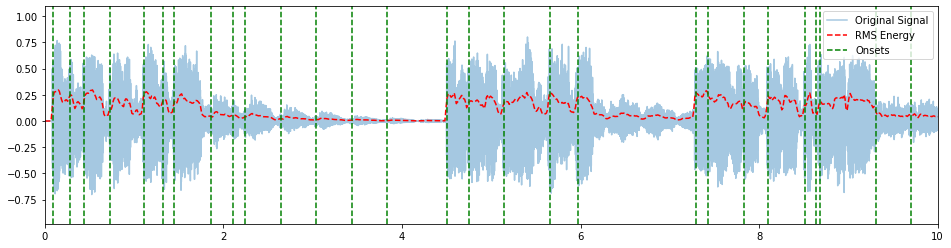

In [6]:
###### Estimate One Audio Files ######

# For the tempo that can't get calculated, for example the '1327052.LOFI.mp3'
# By changing the autocorrelation threshold will detect the different onsets and get the tempo.
length = 120
auto_thresh = 8 # Changed the threshold for autocorrelation

names = '1327052.LOFI.mp3'
Tempo(names, length, hop_len, frame_len, auto_thresh, graph=True)